In [3]:
# Cell A — Imports and use your existing path variables
import os
import random
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
from PIL import ImageFile

from torch import amp
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

ImageFile.LOAD_TRUNCATED_IMAGES = True

data_folder = r"D:\Python\food-101"
image_folder = os.path.join(data_folder,"images")
meta_folder = os.path.join(data_folder,"meta")

SEED = 3
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 64
num_epochs = 3
save_path = os.path.join(data_folder, "pretrained_food101.pth")


def accuracy_topk(output, target, topk=(1,5)):
    maxk = max(topk)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        res.append(correct[:k].reshape(-1).float().sum(0, keepdim=True).item())
    return res  # returns list [top1_correct_count, top5_correct_count]



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_str = device.type
print("Using device:", device)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


# --- use official meta split ---
with open(os.path.join(meta_folder, "train.txt")) as f:
    train_list = [line.strip() + ".jpg" for line in f]
with open(os.path.join(meta_folder, "test.txt")) as f:
    test_list = [line.strip() + ".jpg" for line in f]

# build label mapping from the folder names
classes = sorted({fp.split('/')[0] for fp in train_list + test_list})
class_to_idx = {c: i for i, c in enumerate(classes)}
num_classes = len(classes)
print("Number of classes:", num_classes)

# turn lists into (path, label) tuples
train_samples = [(os.path.join(image_folder, fp), class_to_idx[fp.split('/')[0]]) for fp in train_list]
val_samples   = [(os.path.join(image_folder, fp), class_to_idx[fp.split('/')[0]]) for fp in test_list]

# wrap with DatasetFolder so it looks like ImageFolder
train_ds = DatasetFolder(root=image_folder, loader=default_loader, extensions=("jpg",),
                         transform=train_transform)
train_ds.samples = train_samples
train_ds.targets = [s[1] for s in train_samples]
train_ds.classes = classes
train_ds.class_to_idx = class_to_idx

val_ds = DatasetFolder(root=image_folder, loader=default_loader, extensions=("jpg",),
                       transform=val_transform)
val_ds.samples = val_samples
val_ds.targets = [s[1] for s in val_samples]
val_ds.classes = classes
val_ds.class_to_idx = class_to_idx

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Using device: cuda
Number of classes: 101
Train size: 75750
Val size: 25250


In [4]:


model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scaler = amp.GradScaler(device=device_str)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=len(train_loader), epochs=num_epochs)

best_acc = 0.0
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    running_top1 = 0
    running_top5 = 0
    total = 0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        with amp.autocast(device_type=device_str):
            outputs = model(images)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)   # runs optimizer.step() internally
        scaler.update()
        # For OneCycleLR call scheduler.step() after optimizer.step()
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        top1, top5 = accuracy_topk(outputs, targets, topk=(1,5))
        running_top1 += top1
        running_top5 += top5
        total += images.size(0)

    train_loss = running_loss / total
    train_acc1 = running_top1 / total
    train_acc5 = running_top5 / total

    # validation (fixed)
    model.eval()
    val_loss, val_top1, val_top5, vtotal = 0.0, 0, 0, 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            with amp.autocast(device_type=device_str):
                outputs = model(images)
                loss = criterion(outputs, targets)

            val_loss += loss.item() * images.size(0)
            t1, t5 = accuracy_topk(outputs, targets, topk=(1,5))
            val_top1 += t1
            val_top5 += t5
            vtotal += images.size(0)

    val_loss /= vtotal
    val_acc1 = val_top1 / vtotal
    val_acc5 = val_top5 / vtotal

    print(f"Epoch {epoch} Train loss {train_loss:.4f} acc1 {train_acc1:.4f} acc5 {train_acc5:.4f} | Val loss {val_loss:.4f} acc1 {val_acc1:.4f} acc5 {val_acc5:.4f}")

    if val_acc1 > best_acc:
        best_acc = val_acc1
        torch.save({"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer": optimizer.state_dict(), "classes": classes}, save_path)
        print("Saved best model", save_path)


Epoch 1 [train]: 100%|█████████████████████████████████████████████████████████████| 1184/1184 [10:53<00:00,  1.81it/s]


Epoch 1 Train loss 3.0272 acc1 0.3937 acc5 0.6433 | Val loss 2.0744 acc1 0.6273 acc5 0.8702
Saved best model D:\Python\food-101\pretrained_food101.pth


Epoch 2 [train]: 100%|█████████████████████████████████████████████████████████████| 1184/1184 [01:31<00:00, 12.91it/s]


Epoch 2 Train loss 2.2624 acc1 0.5753 acc5 0.8119 | Val loss 1.5890 acc1 0.7729 acc5 0.9438
Saved best model D:\Python\food-101\pretrained_food101.pth


Epoch 3 [train]: 100%|█████████████████████████████████████████████████████████████| 1184/1184 [01:32<00:00, 12.75it/s]


Epoch 3 Train loss 1.8398 acc1 0.6990 acc5 0.8863 | Val loss 1.4004 acc1 0.8322 acc5 0.9640
Saved best model D:\Python\food-101\pretrained_food101.pth


Overall accuracy: 0.8322
Top-1 accuracy: 0.8322   Top-5 accuracy: 0.9641


,class,precision,recall,f1,support
0,apple_pie,0.670103,0.520,0.585586,250
64,miso_soup,0.958333,0.920,0.938776,250
74,peking_duck,0.833333,0.860,0.846457,250
73,panna_cotta,0.773438,0.792,0.782609,250
72,pancakes,0.905350,0.880,0.892495,250
71,paella,0.812261,0.848,0.829746,250
70,pad_thai,0.871429,0.976,0.920755,250
69,oysters,0.971311,0.948,0.959514,250
68,onion_rings,0.881423,0.892,0.886680,250
67,omelette,0.757322,0.724,0.740286,250


,class,precision,recall,f1,support
77,pork_chop,0.632768,0.448,0.524590,250
93,steak,0.560538,0.500,0.528541,250
0,apple_pie,0.670103,0.520,0.585586,250
39,foie_gras,0.675556,0.608,0.640000,250
37,filet_mignon,0.663866,0.632,0.647541,250
22,chocolate_mousse,0.662500,0.636,0.648980,250
8,bread_pudding,0.693617,0.652,0.672165,250
56,huevos_rancheros,0.671875,0.688,0.679842,250
82,ravioli,0.706383,0.664,0.684536,250
9,breakfast_burrito,0.748918,0.692,0.719335,250


                         precision    recall  f1-score   support

              apple_pie     0.6701    0.5200    0.5856       250
         baby_back_ribs     0.8247    0.8280    0.8263       250
                baklava     0.8545    0.9160    0.8842       250
         beef_carpaccio     0.9121    0.8720    0.8916       250
           beef_tartare     0.8046    0.8400    0.8219       250
             beet_salad     0.7782    0.7440    0.7607       250
               beignets     0.9004    0.9040    0.9022       250
               bibimbap     0.9012    0.9120    0.9066       250
          bread_pudding     0.6936    0.6520    0.6722       250
      breakfast_burrito     0.7489    0.6920    0.7193       250
             bruschetta     0.7949    0.7440    0.7686       250
           caesar_salad     0.8566    0.9080    0.8816       250
                cannoli     0.8592    0.9520    0.9032       250
          caprese_salad     0.8462    0.8800    0.8627       250
            carrot_cake 

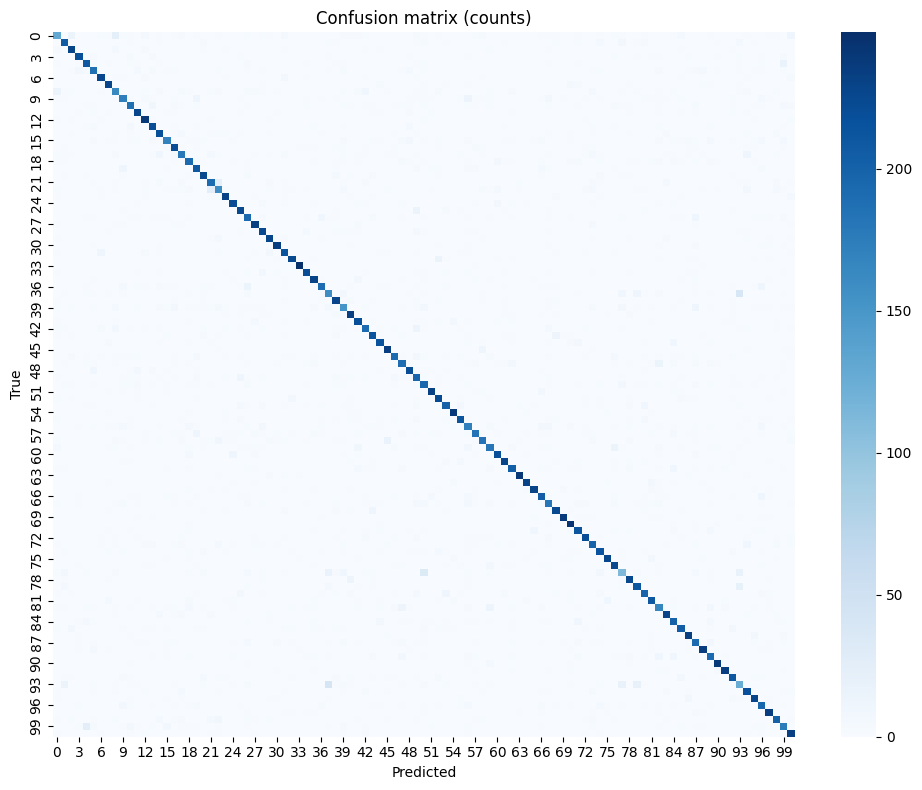

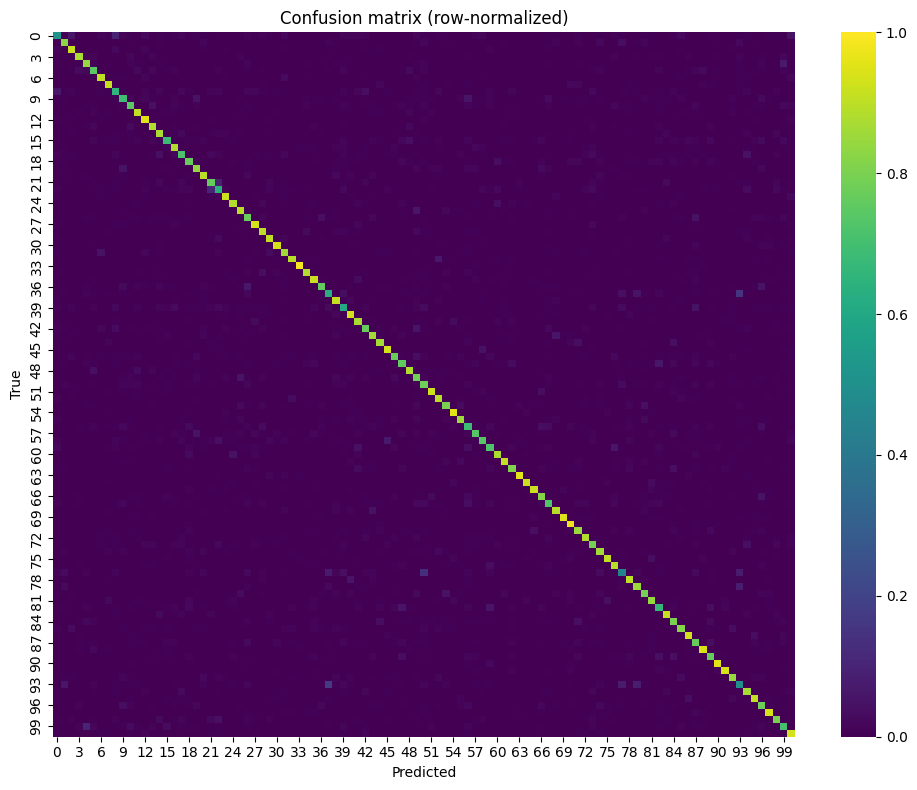

Log loss (cross-entropy): 0.6936


In [5]:
# Drop-in cell — compute metrics on the validation set
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    log_loss,
)
import matplotlib.pyplot as plt
import seaborn as sns  # optional for nicer confusion matrix (pip install seaborn)


model.eval()

all_probs = []
all_preds = []
all_targets = []

softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        outputs = model(images)                # raw logits, shape (B, C)
        probs = softmax(outputs).cpu().numpy() # convert to numpy
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(targets.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Overall accuracy
acc = accuracy_score(all_targets, all_preds)
print(f"Overall accuracy: {acc:.4f}")

# Top-K accuracy (example: top-5)
def topk_accuracy(probs, targets, k=5):
    topk_idx = np.argpartition(-probs, kth=k-1, axis=1)[:, :k]  # faster than full sort
    # For exact ordering (optional): topk_idx = np.argsort(-probs, axis=1)[:, :k]
    hits = [targets[i] in topk_idx[i] for i in range(len(targets))]
    return np.mean(hits)

top1 = topk_accuracy(all_probs, all_targets, k=1)  # should match `acc`
top5 = topk_accuracy(all_probs, all_targets, k=5)
print(f"Top-1 accuracy: {top1:.4f}   Top-5 accuracy: {top5:.4f}")

# Per-class precision / recall / f1 and support (counts)
precision, recall, f1, support = precision_recall_fscore_support(all_targets, all_preds, zero_division=0)
# Show top/bottom classes by support or metrics
import pandas as pd
df_metrics = pd.DataFrame({
    "class": classes,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "support": support
})
df_metrics = df_metrics.sort_values("support", ascending=False)
display(df_metrics.head(10))   # top 10 by support
display(df_metrics.sort_values("f1").head(10))  # worst f1 classes

# Classification report (macro / micro / weighted included)
print(classification_report(all_targets, all_preds, target_names=classes, zero_division=0, digits=4))

# Confusion matrix (counts and normalized)
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", cbar=True)  # if seaborn unavailable, use plt.imshow(cm)
plt.title("Confusion matrix (counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Normalized confusion matrix (per-row = per-true-class recall distribution)
cm_norm = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, cmap="viridis", vmin=0, vmax=1)
plt.title("Confusion matrix (row-normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Log loss (requires probs and one-hot targets)
# Clip probabilities to avoid log(0)
eps = 1e-12
probs_clipped = np.clip(all_probs, eps, 1 - eps)
ll = log_loss(all_targets, probs_clipped, labels=list(range(len(classes))))
print(f"Log loss (cross-entropy): {ll:.4f}")
